In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn 
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [3]:
df = pd.read_csv('PJME_hourly.csv')
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [4]:
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.set_index('Datetime')

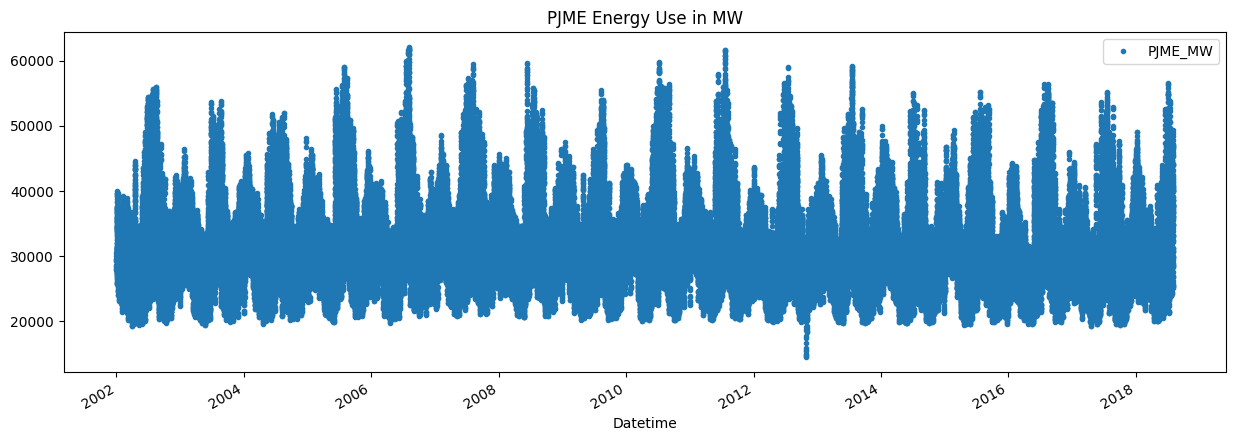

In [5]:
df.plot(style='.', figsize=(15, 5), title='PJME Energy Use in MW')
plt.show()

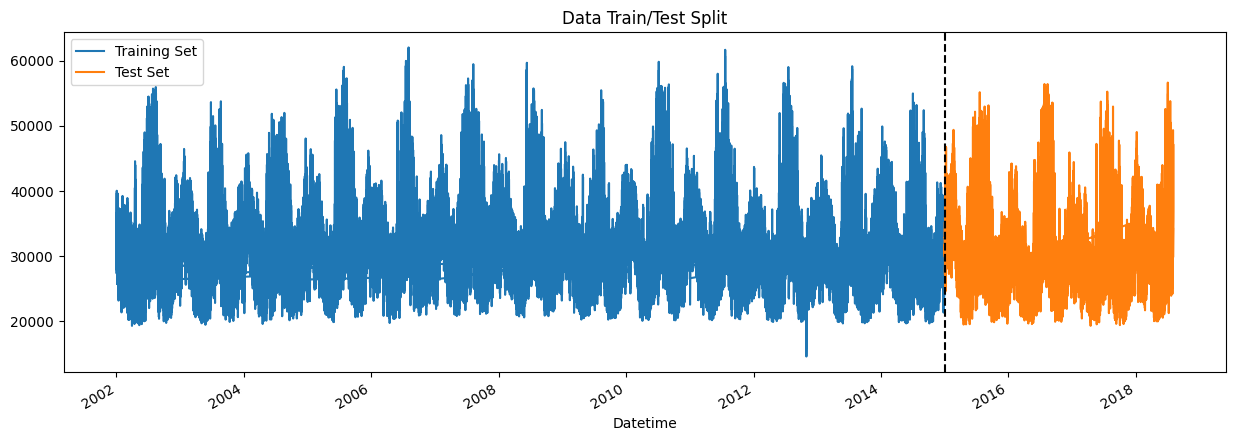

In [6]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [7]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [8]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [9]:
X_train.values

array([[ 365,    1,    1,    4,   12, 2002],
       [ 365,    2,    1,    4,   12, 2002],
       [ 365,    3,    1,    4,   12, 2002],
       ...,
       [   1,   22,    2,    1,    1, 2014],
       [   1,   23,    2,    1,    1, 2014],
       [   2,    0,    3,    1,    1, 2014]], dtype=int32)

In [10]:
y_train.shape, y_test.shape

((113926,), (31440,))

In [11]:
class MLPWithDropout(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, dropout_rate=0.5):
        super(MLPWithDropout, self).__init__()
        
        hidden_dims = [input_dim] + hidden_dims

        self.layers = []
        for i in range(1, len(hidden_dims)):
            self.layers.append(nn.Sequential(
            nn.Linear(hidden_dims[i-1], hidden_dims[i]),
            nn.ReLU(),
            nn.Dropout(dropout_rate)))

        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)

    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return self.output_layer(x)
    
model = MLPWithDropout(6, [1024, 1024, 1024, 1024, 1024], 1)


In [12]:
# Paramètres
batch_size = 256
epochs = 200
learning_rate = 0.05
patience = 3  # Nombre d'époques sans amélioration avant d'arrêter
best_val_loss = float('inf')  # Initialiser la meilleure perte de validation à l'infini
early_stop_counter = 0  # Compteur pour suivre le nombre d'époques sans amélioration

X_train = torch.tensor(X_train.values, dtype=torch.float32)  # Convertir en tenseur
y_train = torch.tensor(y_train.values, dtype=torch.float32)  # Convertir en tenseur

# DataLoader pour gérer les batches
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

model.train()  # Mode entraînement

# Définition de la fonction de perte et de l'optimiseur
criterion = nn.MSELoss()  # Régression -> Mean Squared Error
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

# Boucle d'entraînement avec early stopping
for epoch in range(epochs):
    epoch_loss = 0.0
    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        # Remise à zéro des gradients
        optimizer.zero_grad()

        # Forward pass
        y_pred = model(X_batch)

        # Calcul de la perte
        loss = torch.sqrt(criterion(y_pred, y_batch))

        # Backward pass et optimisation
        loss.backward()
        optimizer.step()

        # Accumuler la perte
        epoch_loss += loss.item()

    # Calcul de la perte moyenne pour cette époque
    avg_epoch_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_epoch_loss:.4f}")
    
    # Early stopping
    if avg_epoch_loss < best_val_loss:
        best_val_loss = avg_epoch_loss
        early_stop_counter = 0  # Réinitialiser le compteur d'amélioration
    else:
        early_stop_counter += 1

    # Vérifier si le critère de patience est atteint
    if early_stop_counter >= patience:
        print(f"Early stopping at epoch {epoch + 1}.")
        break


c:\Users\USER\miniconda3\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\USER\miniconda3\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([6, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/200, Loss: 8128.8191
Epoch 2/200, Loss: 7353.0433
Epoch 3/200, Loss: 7348.1299
Epoch 4/200, Loss: 7354.3423
Epoch 5/200, Loss: 7354.4623
Epoch 6/200, Loss: 7369.1235
Early stopping at epoch 6.


In [13]:
test

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2015-01-01 00:00:00,32802.0,0,3,1,1,2015,1,1,1
2015-12-31 01:00:00,24305.0,1,3,4,12,2015,365,31,53
2015-12-31 02:00:00,23156.0,2,3,4,12,2015,365,31,53
2015-12-31 03:00:00,22514.0,3,3,4,12,2015,365,31,53
2015-12-31 04:00:00,22330.0,4,3,4,12,2015,365,31,53
...,...,...,...,...,...,...,...,...,...
2018-01-01 20:00:00,44284.0,20,0,1,1,2018,1,1,1
2018-01-01 21:00:00,43751.0,21,0,1,1,2018,1,1,1
2018-01-01 22:00:00,42402.0,22,0,1,1,2018,1,1,1


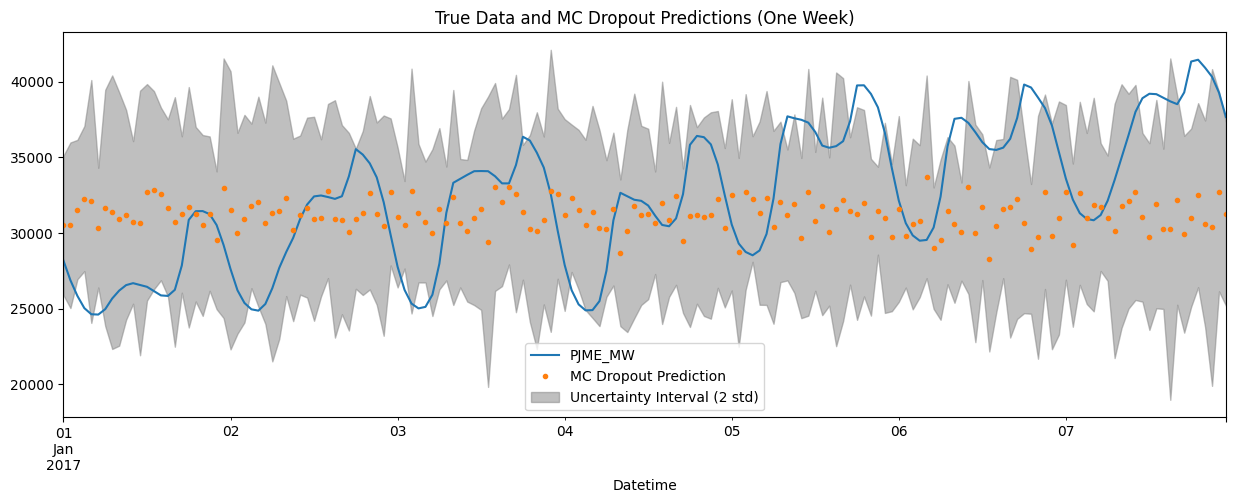

In [14]:
# Fonction pour effectuer les prédictions avec MC Dropout
def predict_with_uncertainty(model, X_test, n_iter=100):
    model.train()  # S'assurer que le modèle est en mode "train" pour activer le dropout
    predictions = []
    
    # Effectuer plusieurs passes (par exemple, n_iter = 100)
    for _ in range(n_iter):
        y_pred = model(X_test)  # Prédiction avec dropout
        predictions.append(y_pred.detach().cpu().numpy())  # Collecter les prédictions

    predictions = np.array(predictions)  # Convertir en tableau numpy
    return predictions

# Assurez-vous que X_test est un tenseur
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

# Effectuer les prédictions avec MC Dropout
n_iter = 10  # Nombre de passes pour obtenir l'incertitude
predictions = predict_with_uncertainty(model, X_test_tensor, n_iter)

# Moyenne et écart-type des prédictions
mean_predictions = predictions.mean(axis=0)
std_predictions = predictions.std(axis=0)

# Ajouter toutes les prédictions et les intervalles dans un DataFrame
test['predictions'] = mean_predictions.flatten()  # Prédiction moyenne
test['std_predictions'] = std_predictions.flatten()  # Intervalle d'incertitude


# Filtrer les données pour une semaine spécifique (ex. une semaine de janvier 2010)
start_date = '2017-01-01'
end_date = '2017-01-07'
test.index = pd.to_datetime(test.index)
test.sort_index(inplace=True)
df_week = test.loc[start_date:end_date]

# Tracer les prédictions et les vraies valeurs
fig, ax = plt.subplots(figsize=(15, 5))

# Tracer les valeurs réelles (True Data)
df_week[['PJME_MW']].plot(ax=ax, label='True Data')

# Tracer les prédictions (Prediction)
df_week['predictions'].plot(ax=ax, style='.', label='MC Dropout Prediction')

# Affichage de l'incertitude (intervalle de confiance à 95% avec 2 écarts-types)
ax.fill_between(df_week.index, df_week['predictions'] - 2 * df_week['std_predictions'], 
                df_week['predictions'] + 2 * df_week['std_predictions'], 
                color='gray', alpha=0.5, label='Uncertainty Interval (2 std)')

# Configurations de l'affichage
plt.legend(loc='best')
ax.set_title('True Data and MC Dropout Predictions (One Week)')
plt.show()
